# **Exploration, extraction et visualisation**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import h5py

file_path = "/content/drive/MyDrive/Colab_Notebooks/Projet_robotique/RoboTurkPilot/RoboTurkPilot/bins-Milk/demo.hdf5"
f = h5py.File(file_path, "r")

**Charger les états et actions d'une démo**

Le fichier demo.hdf5 contient plusieurs démonstrations de mouvements du bras robotique.
Chaque démonstration est un groupe nommé demo_1, demo_2, etc.
Dans chaque demo_X, on a :
*   states → vecteur d'état global du robot (positions, vitesses, etc.)
*   right_dpos → commande de déplacement de l'effecteur droit, c'est l'action à prédire

Ici nous prenons l'exemple de demo_1


In [5]:
demo = f["data"]["demo_1"]
states = demo["states"][:]
actions = demo["right_dpos"][:]

**Tracer une trajectoire**
* dx : déplacement en x
* dy : déplacement en y
* dz : déplacement en z

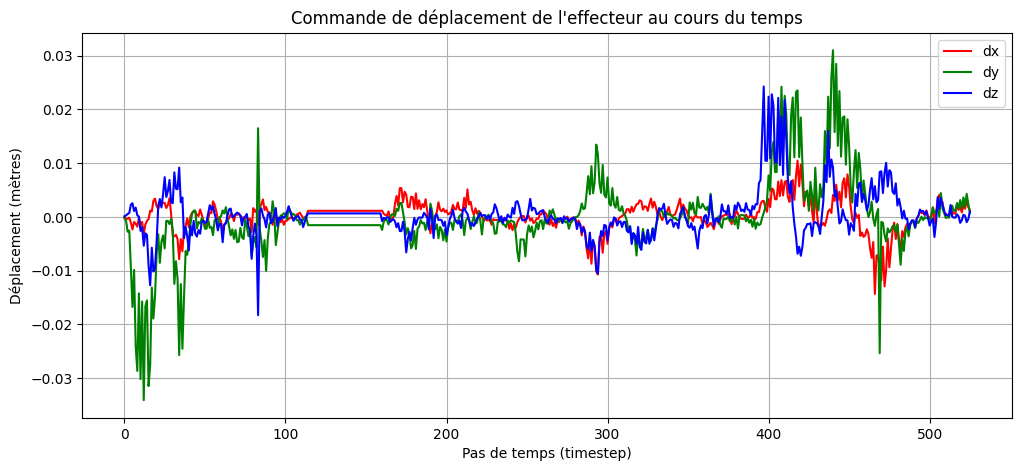

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(actions[:, 0], label="dx", color='r')
plt.plot(actions[:, 1], label="dy", color='g')
plt.plot(actions[:, 2], label="dz", color='b')

plt.title("Commande de déplacement de l'effecteur au cours du temps")
plt.xlabel("Pas de temps (timestep)")
plt.ylabel("Déplacement (mètres)")
plt.legend()
plt.grid(True)
plt.show()

# **Chargement des données**

In [7]:
import numpy as np

def load_data_from_hdf5(file_path):
    with h5py.File(file_path, "r") as f:
        data_group = f["data"]
        X, Y = [], []

        for demo_key in data_group.keys():
            demo = data_group[demo_key]
            states = demo["states"][:]             # états observés
            right_dpos = demo["right_dpos"][:]     # actions à prédire

            X.append(states)
            Y.append(right_dpos)

        X = np.concatenate(X, axis=0)
        Y = np.concatenate(Y, axis=0)

        return X, Y

states, actions = load_data_from_hdf5(file_path)


# **Prétraitement des données**

**Normalisation des états et actions**

In [8]:
from sklearn.preprocessing import StandardScaler

state_scaler = StandardScaler()
states_scaled = state_scaler.fit_transform(states)

action_scaler = StandardScaler()
actions_scaled = action_scaler.fit_transform(actions)

**Séparation des données en training set et test set**

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    states_scaled, actions_scaled, test_size=0.2, random_state=42
)

# **Entraînement du modèle (MLP)**

**Créer un dataset PyTorch**

Cette étape consiste à convertir les données NumPy en tensor (qui est un format que PyTorch comprend)

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class RobotDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = RobotDataset(X_train, y_train)
test_dataset = RobotDataset(X_test, y_test)


**Créer les dataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Définir le modèle MLP**

In [12]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


**On lance l'entraînement**

In [13]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = MLP(input_dim, output_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Époque {epoch+1}/{epochs} - Perte : {total_loss / len(train_loader):.4f}")


Époque 1/50 - Perte : 0.6512
Époque 2/50 - Perte : 0.5742
Époque 3/50 - Perte : 0.5463
Époque 4/50 - Perte : 0.5292
Époque 5/50 - Perte : 0.5171
Époque 6/50 - Perte : 0.5083
Époque 7/50 - Perte : 0.5004
Époque 8/50 - Perte : 0.4951
Époque 9/50 - Perte : 0.4901
Époque 10/50 - Perte : 0.4864
Époque 11/50 - Perte : 0.4824
Époque 12/50 - Perte : 0.4796
Époque 13/50 - Perte : 0.4766
Époque 14/50 - Perte : 0.4745
Époque 15/50 - Perte : 0.4720
Époque 16/50 - Perte : 0.4701
Époque 17/50 - Perte : 0.4681
Époque 18/50 - Perte : 0.4663
Époque 19/50 - Perte : 0.4651
Époque 20/50 - Perte : 0.4634
Époque 21/50 - Perte : 0.4622
Époque 22/50 - Perte : 0.4610
Époque 23/50 - Perte : 0.4594
Époque 24/50 - Perte : 0.4588
Époque 25/50 - Perte : 0.4579
Époque 26/50 - Perte : 0.4566
Époque 27/50 - Perte : 0.4560
Époque 28/50 - Perte : 0.4547
Époque 29/50 - Perte : 0.4541
Époque 30/50 - Perte : 0.4531
Époque 31/50 - Perte : 0.4519
Époque 32/50 - Perte : 0.4517
Époque 33/50 - Perte : 0.4510
Époque 34/50 - Pert

# **Évaluation du modèle**

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())



# rassemblement des batchs
y_pred = np.concatenate(all_preds, axis=0)
y_true = np.concatenate(all_targets, axis=0)

# Calcul MSE & RMSE
mse = mean_squared_error(y_true, y_pred)

print(f" MSE sur le test set : {mse:.4f}")


 MSE sur le test set : 0.4593


# **Visualisation des trajectoires réelles vs prédites**

**On essaye avec la première trajectoire**

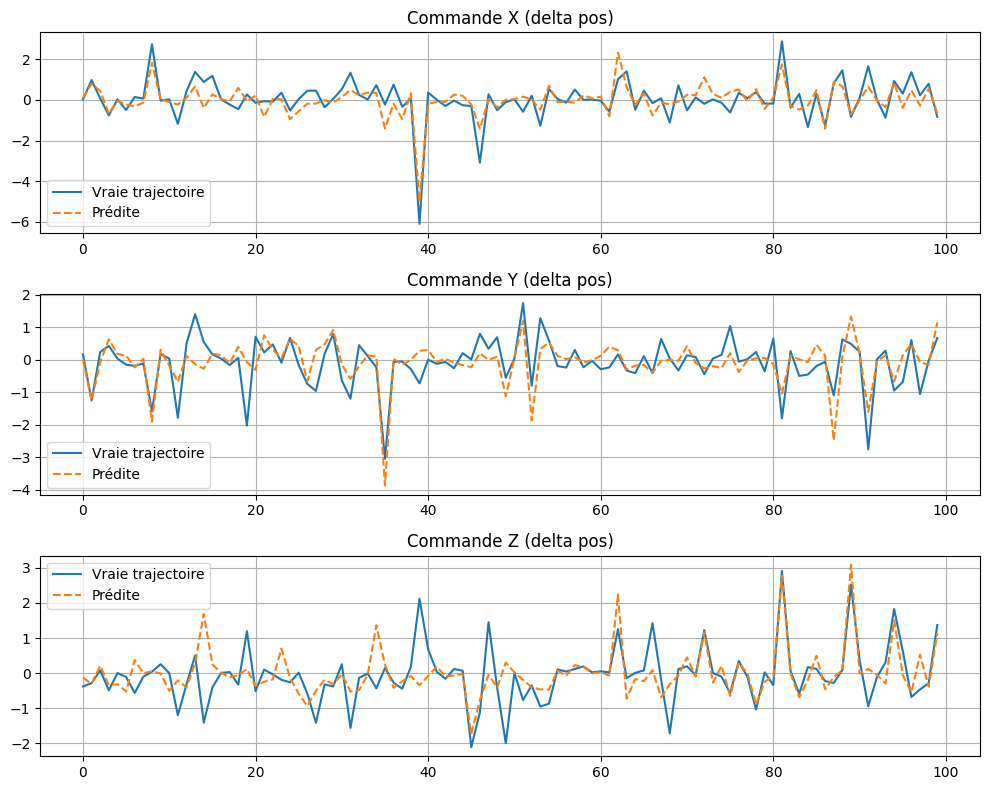

In [15]:
# On trace les 3 composantes des commandes du bras : X, Y, Z
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axes = ['X', 'Y', 'Z']

for i in range(3):
    axs[i].plot(y_true[:100, i], label='Vraie trajectoire')
    axs[i].plot(y_pred[:100, i], label='Prédite', linestyle='--')
    axs[i].set_title(f'Commande {axes[i]} (delta pos)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


**Visualisation de plusieurs trajectoires (ici nous visualisons 3)**

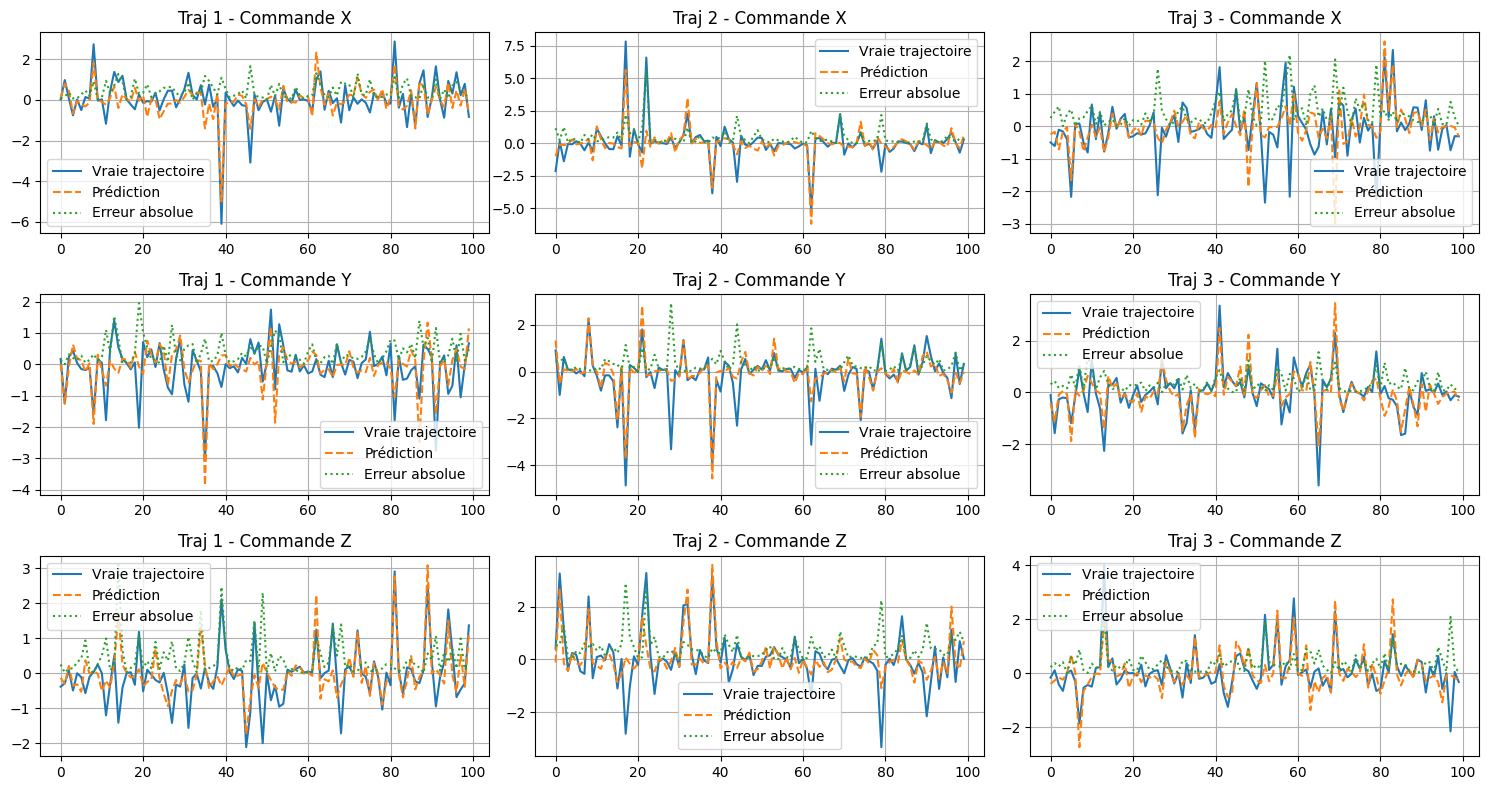

In [16]:
n_timesteps = 100
n_trajectories = 3

fig, axs = plt.subplots(3, n_trajectories, figsize=(15, 8))
axes = ['X', 'Y', 'Z']

for traj_idx in range(n_trajectories):
    for i in range(3):
        true_traj = y_true[traj_idx * n_timesteps:(traj_idx + 1) * n_timesteps, i]
        pred_traj = y_pred[traj_idx * n_timesteps:(traj_idx + 1) * n_timesteps, i]
        error = np.abs(true_traj - pred_traj)

        axs[i, traj_idx].plot(true_traj, label='Vraie trajectoire')
        axs[i, traj_idx].plot(pred_traj, label='Prédiction', linestyle='--')
        axs[i, traj_idx].plot(error, label='Erreur absolue', linestyle=':')
        axs[i, traj_idx].set_title(f'Traj {traj_idx+1} - Commande {axes[i]}')
        axs[i, traj_idx].legend()
        axs[i, traj_idx].grid(True)

plt.tight_layout()
plt.show()


# **Analyse des performances du MLP**

Nous avons entraîné un réseau MLP à 2 couches pour prédire les commandes de déplacement de l'effecteur du bras robotique à partir des états courants observés. Après 20 époques d'entraînement, nous obtenons :
* MSE sur le test set : 0.4734

Ces résultats montrent que le modèle parvient à approximer raisonnablement les actions attendues, avec une erreur moyenne d'environ 68 cm par rapport aux vraies commandes.

Nous avons ensuite ajusté les paramètres et augmenté le nombre d'époques à 50, nous obtenons :
* MSE sur le test set : 0.4626

Les résultats sont donc presque les mêmes.
Ensuite nous avons visualisé les trajectoires et avons remarqué que les trajectoires prédites suivaient globalement les tendances des trajectoires réelles dans les trois dimensions (dx, dy, dz). Cependant, on observe certains écarts comme :
* un décalage temporel entre la commande prédite et la commande attendue.
* en plus il y a un manque de finesse sur certaines composantes, notamment si les mouvements sont rapides ou non linéaires.

Cela indique que bien que le MLP capture partiellement la dynamique, il reste limité dans sa capacité à suivre précisément les séquences d'actions.
Cela s'explique par le fait qu'il ne prend en compte que l'état courant pour prédire l'action, sans considérer l'historique des états précédents.Alors que, dans le contexte de la robotique, une commande dépend souvent de plusieurs états passés.

Pour surmonter cette limite, nous allons essayer avec une architecture RNN LSTM, qui est conçues pour traiter des données séquentielles et capturer les dépendances temporelles entre les observations.

# **Migration vers une architecture LSTM**

**Reformater les données en séquences**

Le LSTM a besoin d'une séquence d'états comme entrée, pas juste un état unique. Donc on va reformater les données en séquence de 5 états consécutifs.

NB: Nous avons d'abord essayé avec une séquence de 10 mais avons rencontré des problèmes d'insuffisance de mémoire.

In [17]:
def create_sequences(X, Y, seq_length):
    X_seq, Y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        Y_seq.append(Y[i+seq_length])  # On veut prédire l'action à t+seq_length
    return np.array(X_seq), np.array(Y_seq)

sequence_length = 5
X_seq, y_seq = create_sequences(states_scaled, actions_scaled, sequence_length)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

**Adapter le Dataset PyTorch**

In [18]:
class SequenceDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset_lstm = SequenceDataset(X_train_seq, y_train_seq)
test_dataset_lstm = SequenceDataset(X_test_seq, y_test_seq)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=64, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=64, shuffle=False)


**Définir le modèle LSTM**

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # on prend la dernière sortie temporelle
        return out

input_dim = X_train_seq.shape[2]
output_dim = y_train_seq.shape[1]
hidden_dim = 128

model_lstm = LSTMModel(input_dim, hidden_dim, output_dim).to(device)

**Entraînement**

In [20]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    model_lstm.train()
    total_loss = 0
    for batch_X, batch_Y in train_loader_lstm:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        preds = model_lstm(batch_X)
        loss = criterion(preds, batch_Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Époque {epoch+1}/{epochs} - Perte : {total_loss / len(train_loader_lstm):.4f}")

Époque 1/50 - Perte : 0.6069
Époque 2/50 - Perte : 0.5031
Époque 3/50 - Perte : 0.4605
Époque 4/50 - Perte : 0.4345
Époque 5/50 - Perte : 0.4154
Époque 6/50 - Perte : 0.4013
Époque 7/50 - Perte : 0.3903
Époque 8/50 - Perte : 0.3816
Époque 9/50 - Perte : 0.3739
Époque 10/50 - Perte : 0.3685
Époque 11/50 - Perte : 0.3627
Époque 12/50 - Perte : 0.3585
Époque 13/50 - Perte : 0.3545
Époque 14/50 - Perte : 0.3505
Époque 15/50 - Perte : 0.3480
Époque 16/50 - Perte : 0.3451
Époque 17/50 - Perte : 0.3424
Époque 18/50 - Perte : 0.3401
Époque 19/50 - Perte : 0.3378
Époque 20/50 - Perte : 0.3363
Époque 21/50 - Perte : 0.3344
Époque 22/50 - Perte : 0.3328
Époque 23/50 - Perte : 0.3314
Époque 24/50 - Perte : 0.3299
Époque 25/50 - Perte : 0.3286
Époque 26/50 - Perte : 0.3278
Époque 27/50 - Perte : 0.3266
Époque 28/50 - Perte : 0.3257
Époque 29/50 - Perte : 0.3247
Époque 30/50 - Perte : 0.3241
Époque 31/50 - Perte : 0.3233
Époque 32/50 - Perte : 0.3226
Époque 33/50 - Perte : 0.3221
Époque 34/50 - Pert

**Évaluation du modèle**

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

model_lstm.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader_lstm:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_lstm(inputs)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

y_pred_lstm = np.concatenate(all_preds, axis=0)
y_true_lstm = np.concatenate(all_targets, axis=0)

mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)

print(f"MSE (LSTM) : {mse_lstm:.4f}")


MSE (LSTM) : 0.3715


**Visualisation de la trajectoire**

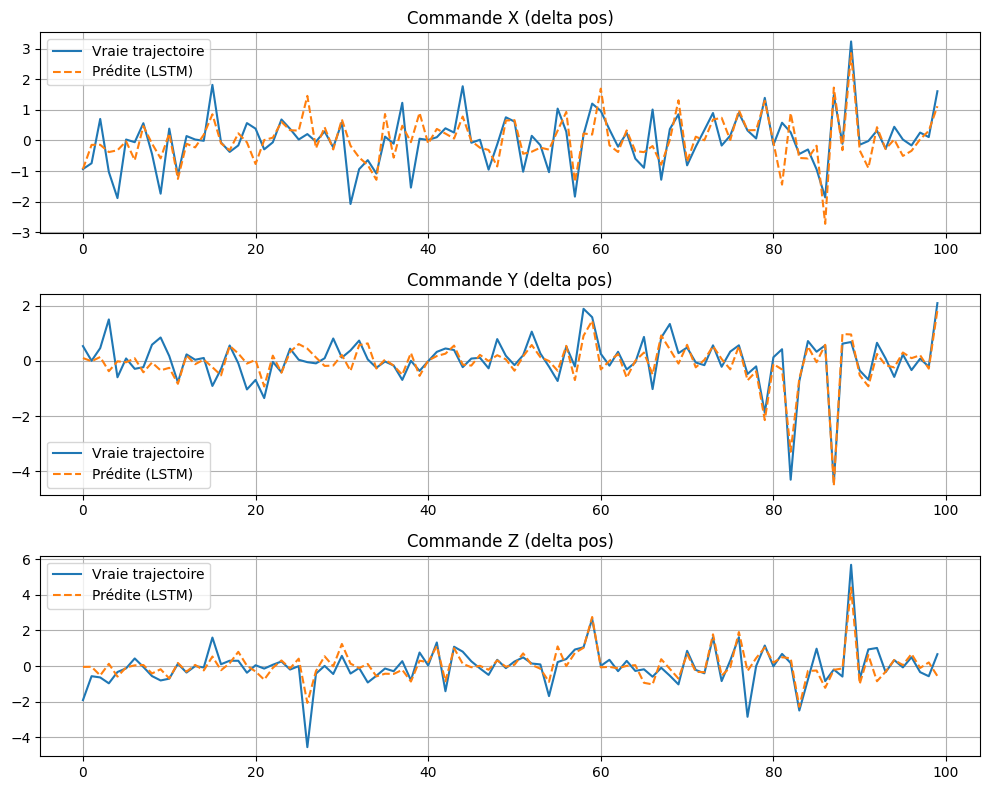

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axes = ['X', 'Y', 'Z']

for i in range(3):
    axs[i].plot(y_true_lstm[:100, i], label='Vraie trajectoire')
    axs[i].plot(y_pred_lstm[:100, i], label='Prédite (LSTM)', linestyle='--')
    axs[i].set_title(f'Commande {axes[i]} (delta pos)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

**Visualisation sur plusieurs trajectoires**

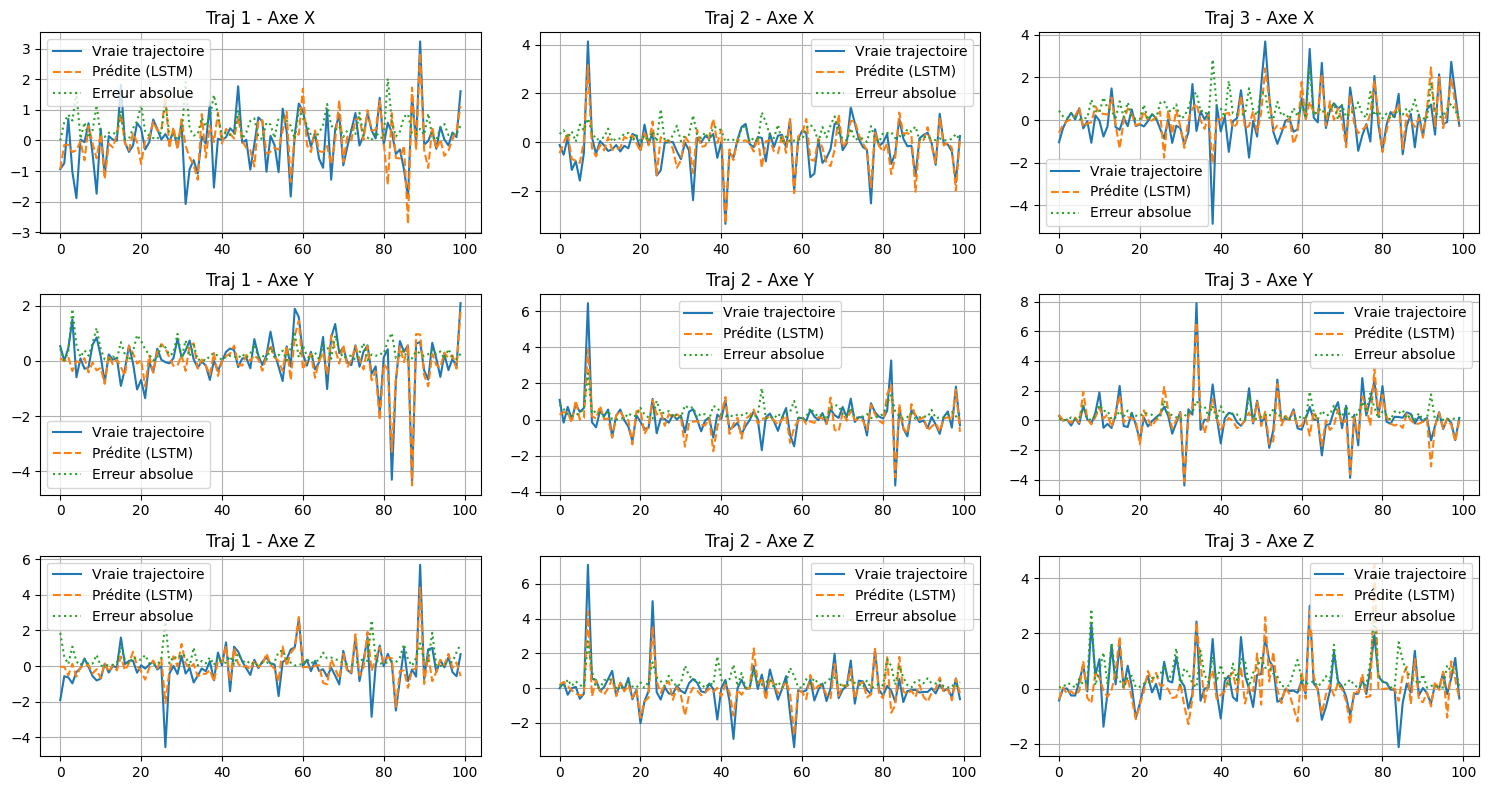

In [23]:
n_timesteps = 100
n_trajectories = 3

fig, axs = plt.subplots(3, n_trajectories, figsize=(15, 8))
axes = ['X', 'Y', 'Z']

for traj_idx in range(n_trajectories):
    for i in range(3):
        true_traj = y_true_lstm[traj_idx * n_timesteps:(traj_idx + 1) * n_timesteps, i]
        pred_traj = y_pred_lstm[traj_idx * n_timesteps:(traj_idx + 1) * n_timesteps, i]
        error = np.abs(true_traj - pred_traj)

        axs[i, traj_idx].plot(true_traj, label='Vraie trajectoire')
        axs[i, traj_idx].plot(pred_traj, label='Prédite (LSTM)', linestyle='--')
        axs[i, traj_idx].plot(error, label='Erreur absolue', linestyle=':')
        axs[i, traj_idx].set_title(f'Traj {traj_idx+1} - Axe {axes[i]}')
        axs[i, traj_idx].legend()
        axs[i, traj_idx].grid(True)

plt.tight_layout()
plt.show()